<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais_sarimax_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [7]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-06-01 16:20:31--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 352.02K  --.-KB/s    in 0.04s   

2022-06-01 16:20:32 (9.41 MB/s) - ‘train.csv’ saved [360467/360467]

--2022-06-01 16:20:32--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: ‘tes

In [8]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [13]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
#idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
#df_treino= df_treino.reindex(idx)
dfx = df_treino[['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room']].resample('H').mean().iloc[1: , ]
df_treino = pd.DataFrame(dfx, columns = ['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room'])
df_treino.fillna(method='ffill', inplace=True)

In [14]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 12:00:00', freq='H'),
 Timestamp('2012-04-11 06:00:00', freq='H'))

In [15]:
df_treino.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 691 entries, 2012-03-13 12:00:00 to 2012-04-11 06:00:00
Freq: H
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CO2_room                          691 non-null    float64
 1   Relative_humidity_room            691 non-null    float64
 2   Lighting_room                     691 non-null    float64
 3   Outdoor_relative_humidity_Sensor  691 non-null    float64
 4   Indoor_temperature_room           691 non-null    float64
dtypes: float64(5)
memory usage: 32.4 KB


In [17]:
dfx = pd.DataFrame(df_treino).reset_index()
dfx['data'] =  dfx['data_hora'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfx.groupby('data')['data_hora'].count().reset_index().sort_values('data')

,data,data_hora
0,2012-03-13,12
1,2012-03-14,24
2,2012-03-15,24
3,2012-03-16,24
4,2012-03-17,24
5,2012-03-18,24
6,2012-03-19,24
7,2012-03-20,24
8,2012-03-21,24
9,2012-03-22,24


In [22]:
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-03-13"]
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-04-11"]

In [23]:
df_treino.head(5)

,CO2_room,Relative_humidity_room,Lighting_room,Outdoor_relative_humidity_Sensor,Indoor_temperature_room
data_hora,,,,,
2012-03-14 00:00:00,224.91450,43.156650,13.232500,57.775325,19.290175
2012-03-14 01:00:00,225.70925,43.221325,13.175500,57.902000,18.657825
2012-03-14 02:00:00,226.18150,43.164000,13.423475,57.386000,18.035150
2012-03-14 03:00:00,219.42150,42.998000,13.346675,56.443300,17.412825
2012-03-14 04:00:00,214.63725,42.787325,13.179850,56.068675,16.817650


In [26]:
df_treino['umidade_interna'] = df_treino['Relative_humidity_room'].map(lambda x: x/2)

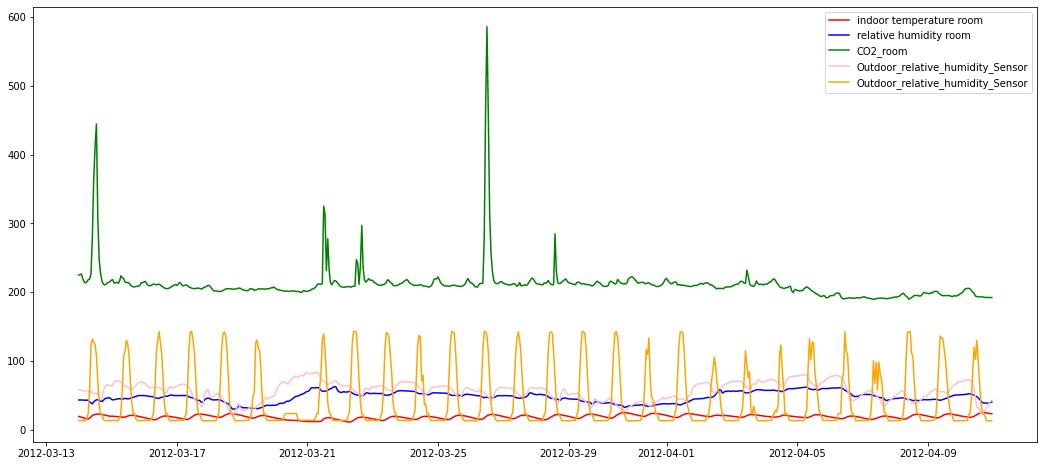

In [24]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(df_treino['Indoor_temperature_room'], color='red', label = 'indoor temperature room')
plt.plot(df_treino['Relative_humidity_room'], color='blue', label = 'relative humidity room')
plt.plot(df_treino['CO2_room'], color='green', label = 'CO2_room')
plt.plot(df_treino['Outdoor_relative_humidity_Sensor'], color='pink', label = 'Outdoor_relative_humidity_Sensor')
plt.plot(df_treino['Lighting_room'], color='orange', label = 'Outdoor_relative_humidity_Sensor')
plt.legend()
plt.show()



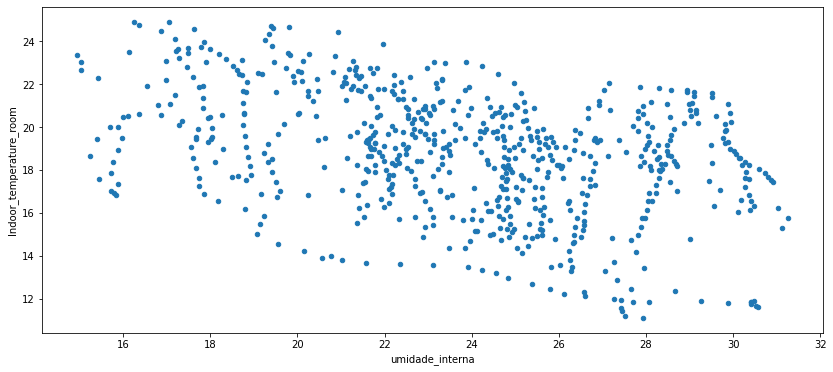

In [27]:
df_treino.plot.scatter('umidade_interna','Indoor_temperature_room', figsize=(14,6))

In [28]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(600, 6) (72, 6)
2012-03-14 00:00:00 2012-04-07 23:00:00
2012-04-08 00:00:00 2012-04-10 23:00:00


In [38]:
scaler = MinMaxScaler()
treino_values = scaler.fit_transform(dfTreino[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
teste_values = scaler.fit_transform(dfTeste[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
dfTreino_tmp = pd.DataFrame(treino_values, columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'] )
dfTreino = dfTreino[['Indoor_temperature_room']]
for c in dfTreino_tmp.columns:
  dfTreino[c] = dfTreino_tmp[c].tolist()
 
dfTeste_tmp = pd.DataFrame(teste_values,  columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'])
dfTeste = dfTeste[['Indoor_temperature_room']]
for c in dfTeste_tmp.columns:
  dfTeste[c] = dfTeste_tmp[c].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [39]:
dfTreino.head(3)

,Indoor_temperature_room,Relative_humidity_room,CO2_room,Outdoor_relative_humidity_Sensor,Lighting_room
data_hora,,,,,
2012-03-14 00:00:00,19.290175,0.406682,0.089145,0.574361,0.005741
2012-03-14 01:00:00,18.657825,0.408666,0.091149,0.576465,0.005304
2012-03-14 02:00:00,18.035150,0.406907,0.092340,0.567895,0.007205


In [31]:
from statsmodels.formula.api import ols

# Ajusta o modelo de regressão linear simples para Close com IBOV/1000 como preditora
modelo = ols('Indoor_temperature_room ~ Relative_humidity_room + CO2_room + Outdoor_relative_humidity_Sensor + Lighting_room',data=dfTreino)
res = modelo.fit()

# valores ajustados de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

In [ ]:
'''from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure( figsize=(14,6))
ax = fig.add_subplot(111, projection = '3d')

x = df_treino['Indoor_temperature_room']
y = df_treino['Relative_humidity_room']
z = df_treino['CO2_room']

ax.set_xlabel("Indoor_temperature_room")
ax.set_ylabel("Relative_humidity_room")
ax.set_zlabel("CO2_room")

ax.scatter(x, y, z)

plt.show()
'''

'from mpl_toolkits.mplot3d import Axes3D\nsns.set(style = "darkgrid")\n\nfig = plt.figure( figsize=(14,6))\nax = fig.add_subplot(111, projection = \'3d\')\n\nx = df_treino[\'Indoor_temperature_room\']\ny = df_treino[\'Relative_humidity_room\']\nz = df_treino[\'CO2_room\']\n\nax.set_xlabel("Indoor_temperature_room")\nax.set_ylabel("Relative_humidity_room")\nax.set_zlabel("CO2_room")\n\nax.scatter(x, y, z)\n\nplt.show()\n'

No handles with labels found to put in legend.


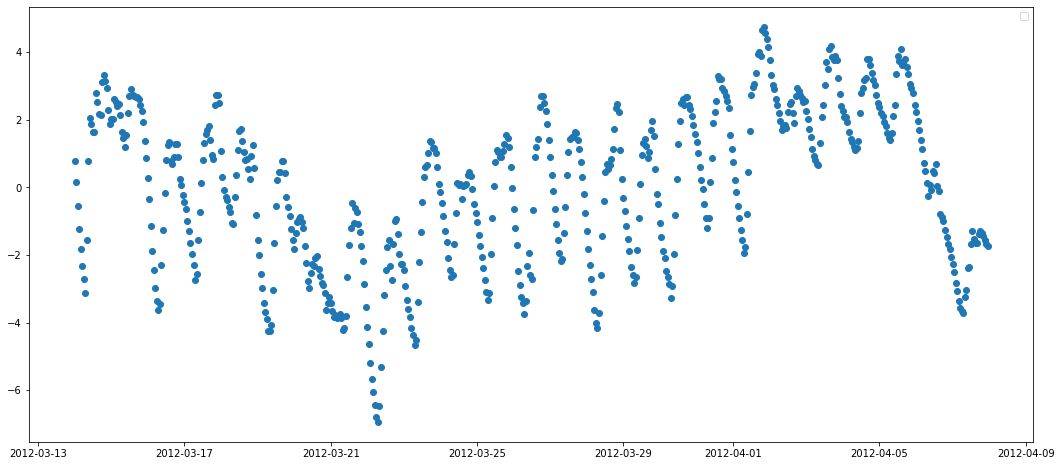

In [32]:
fig, ax = plt.subplots(figsize=(18,8))
plt.scatter(residuo.index,residuo)
plt.legend()
plt.show()

No handles with labels found to put in legend.


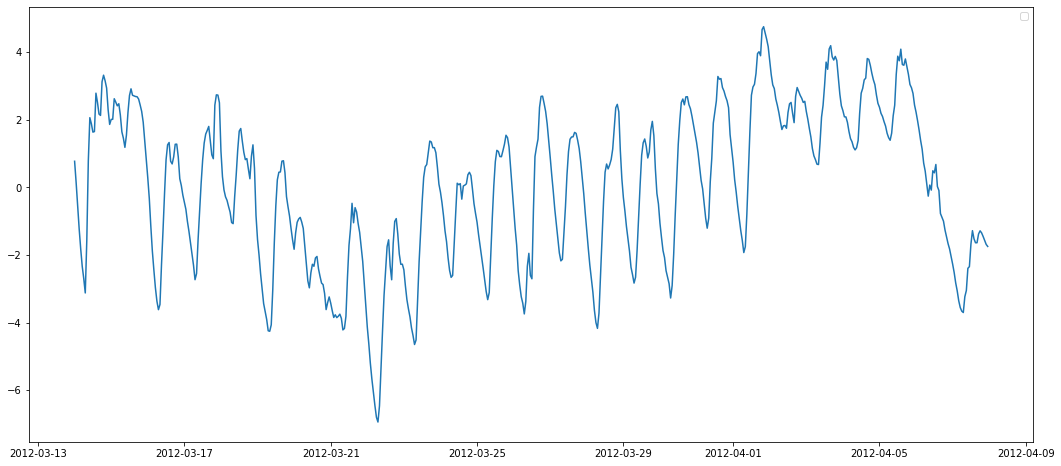

In [33]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(residuo)
plt.legend()
plt.show()

In [35]:
stepwise_fit = auto_arima(residuo, start_p=2, start_q=2,
                          max_p=2, max_q=2, m=24,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=12.01 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=879.646, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=467.420, Time=1.57 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=534.907, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=877.688, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=501.860, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=448.250, Time=6.24 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=22.19 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=6.96 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=6.41 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=436.702, Time=7.94 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=458.611, Time=1.91 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=27.68 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.72 sec
 ARIMA(2,1,1)(2,0,0)[24] intercept   : AIC=438.654, Ti

In [40]:
endog = dfTreino['Relative_humidity_room']
exog = dfTreino['Indoor_temperature_room']

In [41]:
import statsmodels.api as sm

modelo = sm.tsa.statespace.SARIMAX(endog, exog, order=(2,1,0) ,seasonal_order=(2,0,0,24))
resultado = modelo.fit(disp=False)
print(resultado.summary())

                                     SARIMAX Results                                      
Dep. Variable:             Relative_humidity_room   No. Observations:                  600
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 24)   Log Likelihood                1515.726
Date:                            Wed, 01 Jun 2022   AIC                          -3019.452
Time:                                    16:36:37   BIC                          -2993.080
Sample:                                03-14-2012   HQIC                         -3009.185
                                     - 04-07-2012                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Indoor_temperature_room    -0.0172      0.003     -6.341      0.000      -0.023      -0.

In [42]:
start=len(dfTreino)
end=len(dfTreino)+len(dfTeste)-1
exog_forecast = dfTeste[['Indoor_temperature_room']]  
previsao = resultado.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX')

In [43]:
dfTeste['SARIMAX']=previsao

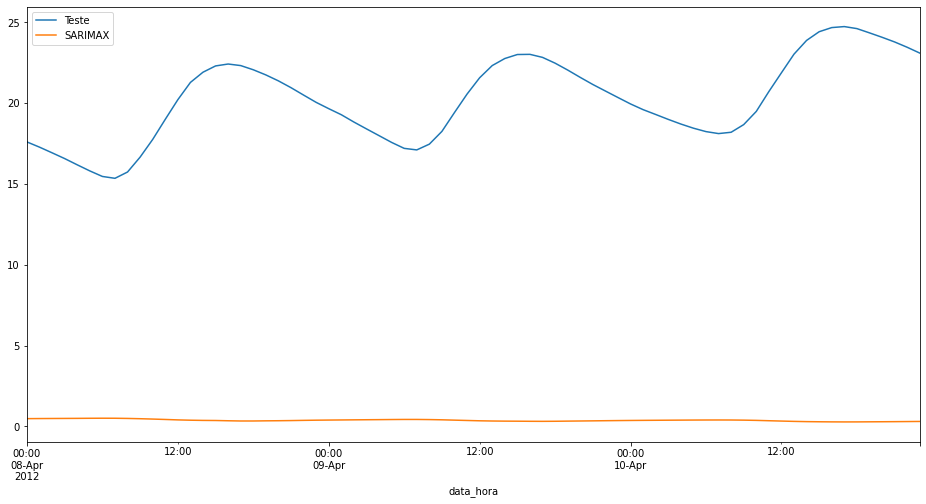

In [44]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['SARIMAX'])